# Fundamentals of Computer Vision: Applied Projects


This Jupyter notebook series contains the bases of the laboratories you need to develop during the semester.

The main goal of those projects is twofold: 1st is to reiterate the theoretical context of the lectures and 2nd to use those methods in adapted examples for real-world scenarios.

## Deadlines

- **Follow-up:** 26/10 15:00h
  - Jupyter executed with all the work done until the moment
- **Deliverable** 3/11 23:55h
  - Report
  - Code
  - Data

*See practicum presentation slides for more detailed information*

## Import libraries, util functions and test image loading



Libraries that you can use (not mandatory) and some auxiliar functions that could be useful on this block.

In [ ]:
# Importing working libraries
import os
import cv2
import torch
import random
import urllib3
import imutils
import math as m
import numpy as np
import torch.nn as nn
import tensorflow as tf
from google.colab import drive # Comment when working in VSC
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow # Comment when working in VSC
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Import from my google drive
drive.mount('/content/drive') # Comment when working in VSC

# Load image path to test functions
# For VSC:
#path_images = "./images" # It doesn't work in google colab because the file management is different.
# For Google Colab:
path_images = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/UAB23-Computer-Vision-Labs/Lab 1/images"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def add_noise(image, noise_type, mean=0, std=0.01, amount=0.05, salt=0.5):
    """
    Add noise to an image.

    Parameters:
    - image: numpy array of shape (H, W) for grayscale or (H, W, 3) for RGB
    - noise_type: string, one of 'gaussian', 'salt_pepper', 'speckle'
    - params: dictionary containing parameters specific to the noise type

    Returns:
    - noisy_image: numpy array with added noise
    """

    if noise_type == 'gaussian':
        sigma = std**0.5
        noise = np.random.normal(mean, sigma, image.shape).astype(image.dtype)
        noisy_image = cv2.add(image, noise)

    elif noise_type == 'salt_pepper':
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * salt)
        coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount*image.size*(1. - salt))
        coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        noisy_image = out

    elif noise_type == 'speckle':
        noise = np.random.randn(*image.shape).astype(image.dtype)
        noisy_image = image + image * noise

    else:
        raise ValueError(f"Noise type '{noise_type}' is not supported.")

    # Clip values to be in [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

def add_periodic_noise(image, frequency=5, amplitude=10):
    X, Y = np.meshgrid(np.arange(image.shape[0]),np.arange(image.shape[1]))

    noise = amplitude * np.sin(2 * np.pi * frequency * Y / image.shape[0])

    noisy_image = image + noise

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image


# Block 1. Linear filtering
This block focuses on linear filtering, one of the foundational concepts in image processing and computer vision. We'll be delving deep into how convolution operates, the distinction between convolution and correlation, and the magic of the Fourier transform in image filtering.

### Objectives:

1. **Implement and Learn How Convolution Works:**  
   A self-implemented convolution function and its application on sample images.

2. **Use Convolution to Apply Linear Filters:**  
   Blurred and edge-detected versions of input images using your convolution function.

3. **Compare Convolution and Correlation:**  
   Implementation of correlation function and comparison with convolution.

4. **Normalized Cross-Correlation and Use for Template Matching:**  
   Function to locate a template within a larger image.

5. **Fourier Transform and Image Filtering:**  
   Filtered images emphasizing or de-emphasizing certain frequency components.

---

### Mandatory Questions:

- What is the purpose of image filtering in computer vision? Can you list some common applications?
   - Attenuate or emphasize features, regions or properties of the scene contained in an image in order to meet a specific need. Image editing, blur, contour detection, noise reduction, smoothing, contrast enhancement, etc.

- Why do we often use odd-sized kernels in image filtering? When we want to use even-sized filters?
   - Because we usually want to treat each pixel according to the region around it, by using odd-dimensional kernels, we ensure that the kernel will have a single central element that we can use as the center when performing calculations. An even-dimensional kernel would be useful if we want to treat a set of pixels or a region of the image at the same time, also when we want to reduce the computational work and increase the stride in order to process the given image faster.

- Why do we often use a flipped version of the kernel in the convolution operation?
   - The process lies in the mathematical foundations of convolution, which is a special case of cross-correlation. By flipping the kernel we ensure that the operations correspond correctly to the pixel-by-pixel alignment of the image matrix.

- What is the fundamental difference between convolution and correlation? Can you demonstrate this with an example?
   - In convolution, kernel flipping is performed, a process that is not performed in correlation, for example, by having the kernel as a basis:
      - 1 0 1
      - 0 0 1
      - 1 0 0
   - in the convolution its flipped version would be used:
      - 0 0 1
      - 1 0 0
      - 1 0 1
   - while the correlation would keep the original kernel without applying any additional process, obtaining the kernel:
      - 1 0 1
      - 0 0 1
      - 1 0 0

- How does changing the size of the kernel affect the outcome of the convolution operation?
   - Each pixel will be transformed according to the area surrounding it being this increasingly larger or smaller as the kernel size varies, i.e., using a kernel of dimension 1x1, the pixel will be transformed based only on its properties, by increasing the kernel to 3x3, now the pixel will be transformed not only according to it, but also with respect to its immediate neighbors, in the dimension 5x5 neighbors of neighbors will also be considered for the transformation of the pixel and so on. The specific results of this kernel size variation will depend entirely on the kernel in use, for example, in the case of blur kernels the image smoothing will be increased or in contour detection, the contours will be wider; it all depends on the kernel in use.

- Explain the process of convolution and how it is used to apply a filter to an image.
   - Convolution requires two main components: the image to be filtered and the kernel to be applied to the image. First, the kernel must be flipped on both axes, in order to fulfill the mathematical background of the convolution; then we will have to go through all the pixels of the image subtracting the region of equivalent size to the kernel, once it has been centered on the current pixel; with this region and the kernel, the weighted sum is performed, placing in the output matrix the value obtained in the position equivalent to that of the image pixel used. The output matrix, at the end of the process on the whole image, will have been filtered by the given kernel.

- In your own words, explain the significance of the Fourier transform in image processing.

- Describe the process and the underlying principle of template matching using normalized cross-correlation.
   - In the NCC the process to follow will be similar to that of the convolution in the sense that we will go through each pixel of the image obtaining a new value, the difference is that the kernel flipping will not be performed (so we will follow more a correlation scheme as the name says) and the value will be obtained in a different way than the weighted sum. Obtaining values by NCC is done by identifying the quantitative squared difference, existing between a given template and a specific region of the same size as that template; therefore, if we want to find the most similar region, what we must do is to minimize this value. By the properties of the difference of squares, we will always have two constant terms and one variable, so we can focus only on the variable that is subtracting from the rest of the equation, so, if we only focus on this term to find the match between template and image region, given that the variable term subtracts from the rest of the equation, what we will seek will be to maximize its value. Finally, to keep all the pixel values of the image under the same range and to avoid that the match is benefited by increasing pixel intensities, we will perform the normalization of the values and this will be used as the divisor of the variable term. Thus obtaining the NCC formula which, at its maximum values, will give us the regions with the highest coincidence in the image according to a specific template.

- Why might one choose to operate in the frequency domain (using Fourier transform) instead of the spatial domain when processing an image?

- Can we remove "salt and pepper" noise with some of those linear filters?  


### Optional Deep Dive Questions:

- Besides convolution, what are other methods to apply filters to an image? Can you compare and contrast these methods?

- Explore the concept of separable kernels. What benefits do they provide in convolution?

- What is the purpose of the padding in the convolution operation, and what are the different types of padding? Explain also the purpose of stride and how this affects the output?

- Explain which types of filters might be important for a real-scenario application (e.g., self-driving car vision system, medical image analysis).

- What are the limitations of linear filters when it comes to noise reduction? Are there scenarios where they might not be ideal?

- How would might you extend the concepts of convolution to color images? Which complexities arise when dealing with multiple channels?

- Fourier transform is used in various fields outside of image processing. Can you find and explain an application outside of computer vision?

- Explore and explain the difference between the discrete Fourier transform (DFT) and the fast Fourier transform (FFT). Why might FFT be preferred in many applications?


## Convolution operation



#### Objective:
Implement the convolution operation by hand and compare it with standard library functions. Also, manipulate image sizes through upsampling and downsampling using convolution. The focus will be on handling edge cases and experimenting with various kernels.

---

#### Guideline:
1. Implement a function to perform the convolution operation on an image. Make sure to handle edge cases and allow for different kernel sizes. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Develop methods for upsampling and downsampling images using your convolution function.
3. Experiment with your convolution function by applying different kernels on various images.
4. Compare your hand-implemented convolution outcomes with standard library methods such as OpenCV's `filter2d` and SciPy's `convolve`.

---

#### Expected results:
- Your hand-implemented convolution, upsampling, and downsampling code.
- Resized images at scales: (2x, 0.5x).

In [ ]:
# In this cell you will find the four functions requested

def convolution(image, kernel, padding="SAME", stride=1):

    # Checking parameters
    if not(isinstance(image, np.ndarray) or image is None):
        raise ValueError("The 'image' parameter must be a NumPy matrix")
    if not(len(image.shape) == 2):
      raise ValueError("The 'image' parameter must be in greyscale (3D -> 2D)")
    if not(isinstance(kernel, np.ndarray)):
        raise ValueError("The 'kernel' parameter must be a NumPy matrix")
    if not(image.shape[0] >= kernel.shape[0] and image.shape[1] >= kernel.shape[1]):
      raise ValueError("The 'kernel' size must be less than or equal to the image size in both dimensions")
    if not(isinstance(stride, int) or stride <= 0):
        raise ValueError("The 'stride' parameter must be a strictly positive integer")
    if not(padding == "SAME" or padding == "VALID"):
        raise ValueError("The 'padding' parameter must be 'SAME' or 'VALID', any other parameter is invalid")

    # Type conversion
    image = image.astype(np.float64)
    kernel = kernel.astype(np.float64)

    # Flipping the kernel
    kernel = np.flip(kernel, 0)
    kernel = np.flip(kernel, 1)

    # Image and kernel dimensions
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Converting padding to numbers
    padding_value_height, padding_value_width = 0, 0
    if padding == "SAME":
        padding_value_height = kernel_height // 2
        padding_value_width = kernel_width // 2

    # Output size calculation
    out_height, out_width = 0, 0
    if padding == "SAME":
        out_height = m.ceil(image_height / stride)
        out_width = m.ceil(image_width / stride)
    else:
        out_height = (image_height + 2 * padding_value_height - kernel_height) // stride + 1
        out_width = (image_width + 2 * padding_value_width - kernel_width) // stride + 1

    # Initialization of the output matrix
    output = np.zeros((out_height, out_width))
    output = output.astype(np.float64)

    # Padded image initialization
    pad_size = ((padding_value_height, padding_value_height), (padding_value_width, padding_value_width))
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    padded_image = padded_image.astype(np.float64)

    # Iteration
    for i in range(0,output.shape[0]):
        for j in range(0,output.shape[1]):
            # Image region recovery
            image_region = padded_image[i*stride:i*stride+kernel_height,j*stride:j*stride+kernel_width]
            # Calculating the scalar product between the image region and the kernel
            output[i,j] = np.sum(image_region * kernel)

    # Result
    return(output)


def gaussian_kernel(size, sigma):

    if size%2==0:
      raise ValueError("The kernel size must be an odd number.")

    kernel = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2))*np.exp(-((x-(size//2))**2+(y-(size//2))**2)/(2*sigma**2)),
        (size, size)
    )

    return(kernel/np.sum(kernel)) # Normalize the kernel so that the sum equals 1


def upscale_image(image, scale_factor):

    # Parameter verification
    if not isinstance(scale_factor, int) or scale_factor <= 1:
        raise ValueError("The 'scale_factor' parameter must be an integer greater than 1.")

    # Get the dimensions of the input image
    height, width = image.shape

    # Calculate the new dimensions
    new_height = height * scale_factor
    new_width = width * scale_factor

    # Create a new image with upsampled dimensions
    upscaled_image = np.zeros((new_height, new_width))
    upscaled_image[::scale_factor, ::scale_factor] = image

    # Prepare the convolution kernel
    kernel_size = 2 * scale_factor - 1
    middle = scale_factor - 1
    kernel = (1/4) * np.ones((kernel_size, kernel_size))
    kernel[:, middle] = 1/2
    kernel[middle, :] = 1/2
    kernel[middle, middle] = 1

    # Convolution of the upsampled image
    upscaled_image = convolution(upscaled_image, kernel, padding="SAME", stride=1)

    return upscaled_image


def downscale_image(image, scale_factor):

    # Parameter verification
    if not isinstance(scale_factor, int) or scale_factor <= 1:
        raise ValueError("The 'scale_factor' parameter must be an integer greater than 1.")

    # Prepare the convolution kernel for blurring
    kernel_size = 2 * scale_factor - 1
    kernel = (1/(kernel_size**2)) * np.ones((kernel_size, kernel_size))

    # Convolution to downsampled the image
    downsampled_image = convolution(image,kernel,padding="SAME",stride=scale_factor)

    return downsampled_image


In [ ]:
# In this cell, you will find function to test our own convolution function in the next cell.

def testing_convolution_function_with_scipy(image_original, iteration_number=20, coefficient_value_range=10, coefficients_type="random", stride_range=10, kernel_size_range=10, precision=6):
  # Iterating over the number of tests
  for i in range(iteration_number):
    print("")
    print("----> Iteration ", i + 1)
    # Generating parameters
    stride = random.randint(1, stride_range)
    kernel_size_x = random.randint(1, kernel_size_range)
    kernel_size_y = random.randint(1, kernel_size_range)
    kernel_size = (kernel_size_x,kernel_size_y)
    # Generating a random kernel
    kernel = np.empty(kernel_size)
    if coefficients_type == "random":
      coefficients_type_ = random.choice(["int", "float"])
    else:
      coefficients_type_ = coefficients_type
    if coefficients_type_ == "int":
      kernel = np.random.randint(-coefficient_value_range, coefficient_value_range, size=kernel_size)
    elif coefficients_type_ == "float":
      kernel = np.round(np.random.uniform(-coefficient_value_range, coefficient_value_range, size=kernel_size), precision)
    # Displaying parameters for the user
    print("\nParameters : \n")
    print("Kernel = \n", kernel)
    print("kernel_size_x : ",kernel_size_x)
    print("kernel_size_y : ",kernel_size_y)
    print("stride : ",stride)
    # Custom convolutions (to be verified)
    image_convolution_perso_same = convolution(image_original, kernel, padding="SAME", stride=stride)
    image_convolution_perso_valid = convolution(image_original, kernel, padding="VALID", stride=stride)
    # Scipy convolutions (already functional for verification)
    image_convolution_scipy_same = convolve2d(image_original, kernel, mode='same')[::stride, ::stride]
    image_convolution_scipy_valid = convolve2d(image_original, kernel, mode='valid')[::stride, ::stride]
    # Results of the convolutions comparison
    print("\nResults of the convolutions comparison : \n")
    # Validity test for padding="same"
    if np.array_equal(np.round(image_convolution_perso_same, precision), np.round(image_convolution_scipy_same, precision)):
      print("padding='same' : --> EQUAL : Our convolution function and that of Scipy give the same result")
    else:
      print("padding='same' : --> NOT EQUAL : Our convolution function and that of Scipy do not give the same result")
    # Validity test for padding="valid"
    if np.array_equal(np.round(image_convolution_perso_valid, precision), np.round(image_convolution_scipy_valid, precision)):
      print("padding='valid' : --> EQUAL : Our convolution function and that of Scipy give the same result")
    else:
      print("padding='valid' : --> NOT EQUAL : Our convolution function and that of Scipy do not give the same result")
  print(" ")

def display_separation(text):
  print("")
  print("-------------------------------------------------------------------")
  print("")
  print("------> ",text)



-------------------------------------------------------------------

------>  Convolution function test

----> Iteration  1

Parameters : 

Kernel = 
 [[ 51.321133  61.577225]
 [-79.14393   -4.183043]
 [ 36.62746   -4.018862]
 [-25.986546 -28.812676]]
kernel_size_x :  4
kernel_size_y :  2
stride :  3

Results of the convolutions comparison : 

padding='same' : --> EQUAL : Our convolution function and that of Scipy give the same result
padding='valid' : --> EQUAL : Our convolution function and that of Scipy give the same result

----> Iteration  2

Parameters : 

Kernel = 
 [[-60.767945  71.34561  -71.783235  32.322553 -21.036769  66.251925
   63.807346   9.780546 -20.978485 -96.189357]
 [ 33.41462   42.164816 -39.396574  17.555241 -86.248872  43.293732
  -81.908572  68.703522  77.626256  97.775147]
 [ 29.566384  97.500321   1.718313 -62.716642 -19.216704 -20.88795
  -39.525302  21.948796  98.726097  61.659498]
 [-63.180967   2.58199   -8.349008  50.207099  -5.962795  99.882058
   59.1

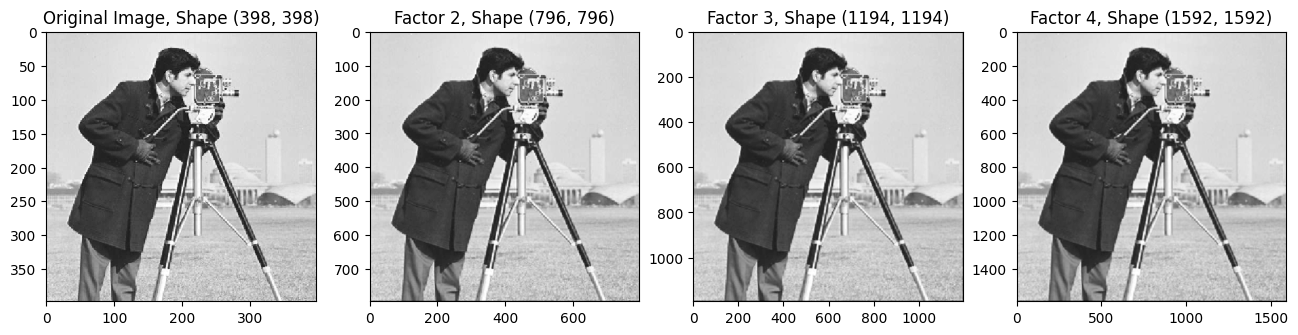


-------------------------------------------------------------------

------>  Downscale Image function test
Downscaling in progress for scale_factor 2
Downscaling in progress for scale_factor 3
Downscaling in progress for scale_factor 4
Downscaling in progress for scale_factor 5


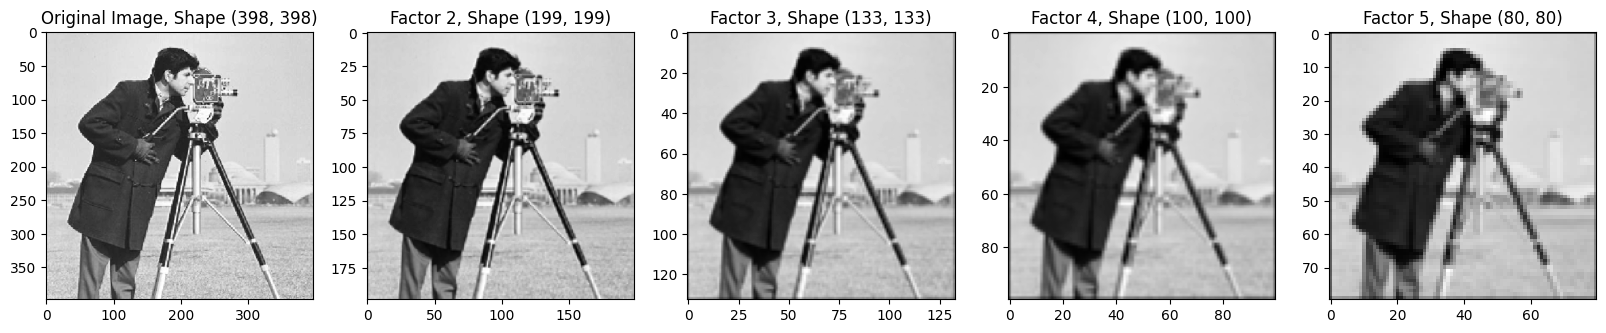

In [ ]:
# In this cell, you will find the tests to prove that the four requested functions work correctly

# Image reading

path = os.path.join(path_images, "cameraman.png")
image_original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Test of the convolution function

display_separation("Convolution function test")
iteration_number = 30
coefficient_value_range = 100
coefficients_type = "random" # "int" or "float"
stride_range = 10
kernel_size_range = 10
testing_convolution_function_with_scipy(image_original,iteration_number=iteration_number, coefficient_value_range=coefficient_value_range, coefficients_type=coefficients_type, stride_range=stride_range, kernel_size_range=kernel_size_range)

# Test of the gaussian_kernel function

display_separation("Gaussian Kernel function test")
for size in range(3, 6, 2):
    for sigma in range(1, 2):
        kernel = gaussian_kernel(size, sigma)
        print("---")
        print("Size = {}, Sigma = {}, Kernel = ".format(size, sigma))
        print(kernel)

# Test of the upscale_image function

display_separation("Upscale Image function test")
scale_factors = [2, 3, 4]
fig, axes = plt.subplots(1, len(scale_factors) + 1, figsize=(4 * (len(scale_factors) + 1), 4))
axes[0].imshow(image_original, cmap='gray')
axes[0].set_title(f"Original Image, Shape {image_original.shape}")
for i, scale_factor in enumerate(scale_factors):
    print(f"Upscaling in progress for scale_factor {scale_factor}")
    upscaled_image = upscale_image(image_original, scale_factor)
    axes[i + 1].imshow(upscaled_image, cmap='gray')
    axes[i + 1].set_title(f"Factor {scale_factor}, Shape {upscaled_image.shape}")
plt.show()

# Test of the downscale_image function

display_separation("Downscale Image function test")
scale_factors = [2, 3, 4, 5]
fig, axes = plt.subplots(1, len(scale_factors) + 1, figsize=(4 * (len(scale_factors) + 1), 4))
axes[0].imshow(image_original, cmap='gray')
axes[0].set_title(f"Original Image, Shape {image_original.shape}")
for i, scale_factor in enumerate(scale_factors):
    print(f"Downscaling in progress for scale_factor {scale_factor}")
    downscaled_image = downscale_image(image_original, scale_factor)
    axes[i + 1].imshow(downscaled_image, cmap='gray')
    axes[i + 1].set_title(f"Factor {scale_factor}, Shape {downscaled_image.shape}")
plt.show()


## Linear Filtering


#### Objective:
Explore various image filtering techniques by applying them to a set of example images as well as images of your own choice. Experiment with different kernel sizes and types of filters to observe their effects.

- Blur:
  - Average Box Filter
  - Gaussian Filter
- Edge:
  - Laplacian Filter
  - Sobel Filter
  - Prewitt Filter

Feel free to experiment with additional filters as well.

---

#### Guideline:
1. Apply each of the given filters to the example images provided.
2. Use images of your own choosing to further experiment with these filters.
3. Experiment with varying kernel sizes for each filter.
4. Analyze the effects of each filter and kernel size on the images.

---

#### Expected results:
- Filtered images (both example and your own)
- Analysis of the effect of kernel size


Examples of different linear filters for blur and edge *detection*

1. **Average Box Filter:**
   ```
   1/9  1/9  1/9
   1/9  1/9  1/9
   1/9  1/9  1/9
   ```

2. **Gaussian Blur Filter:**
   ```
   1/16  2/16  1/16
   2/16  4/16  2/16
   1/16  2/16  1/16
   ```

3. **Laplacian Filter:**
   ```
   0  1  0
   1 -4  1
   0  1  0
   ```

4. **Sobel Operator (horizontal || vertical):**
   ```
     -1  0  1  ||  -1 -2 -1
     -2  0  2  ||   0  0  0
     -1  0  1  ||   1  2  1
  ```

5. **Prewitt Operator (horizontal || vertical):**
   ```
    -1  0  1  || -1 -1 -1
    -1  0  1  ||  0  0  0
    -1  0  1  ||  1  1  1
   ```



In [ ]:
# Kernels definitions

kernel_averageBox = np.array([[1/9,1/9,1/9],
                              [1/9,1/9,1/9],
                              [1/9,1/9,1/9]])

kernel_gaussianBlur = np.array([[1/16,2/16,1/16],
                                [2/16,4/16,2/16],
                                [1/16,2/16,1/16]])

kernel_laplacian = np.array([[0,1,0],
                             [1,-4,1],
                             [0,1,0]])

kernel_sobelOperatorHorizontal = np.array([[-1,0,1],
                                           [-2,0,2],
                                           [-1,0,1]])

kernel_sobelOperatorHorizontal_5x5 = np.array([[1, 2, 0, -2, -1],
[4, 8, 0, -8, -4],
[6, 12, 0, -12, -6],
[4, 8, 0, -8, -4],
[1, 2, 0, -2, -1]])

kernel_sobelOperatorVertical = np.array([[-1,-2,-1],
                                         [0,0,0],
                                         [1,2,1]])

kernel_prewittOperatorHorizontal = np.array([[-1,0,1],
                                             [-1,0,1],
                                             [-1,0,1]])

kernel_prewittOperatorVertical = np.array([[-1,-1,-1],
                                           [0,0,0],
                                           [1,1,1]])

kernel_prewittOperatorVertical_7x7 = np.array([
    [-4, -4, -4, -4, -4, -4, -4],
    [-2, -2, -2, -2, -2, -2, -2],
    [-1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 2, 2],
    [4, 4, 4, 4, 4, 4, 4]
])

kernel_averageBox_5x5 = np.array([[1/25,1/25,1/25,1/25,1/25],
                                    [1/25,1/25,1/25,1/25,1/25],
                                    [1/25,1/25,1/25,1/25,1/25],
                                    [1/25,1/25,1/25,1/25,1/25],
                                    [1/25,1/25,1/25,1/25,1/25]])

kernel_gaussianBlur_5x5 = np.array([
    [1/256, 4/256, 6/256, 4/256, 1/256],
    [4/256, 16/256, 24/256, 16/256, 4/256],
    [6/256, 24/256, 36/256, 24/256, 6/256],
    [4/256, 16/256, 24/256, 16/256, 4/256],
    [1/256, 4/256, 6/256, 4/256, 1/256]
])

kernel_laplacian_5x5 = np.array([[0,0,1,0,0],
                                  [0,1,-1,1,0],
                                  [1,-1,-4,-1,1],
                                  [0,1,-1,1,0],
                                  [0,0,1,0,0]])

kernel_gaussianBlur_7x7 = np.array([
    [1/140, 1/70, 2/140, 2/140, 2/140, 1/70, 1/140],
    [1/70, 2/70, 2/70, 4/140, 2/70, 2/70, 1/70],
    [2/140, 2/70, 4/70, 8/140, 4/70, 2/70, 2/140],
    [2/140, 4/140, 8/140, 16/140, 8/140, 4/140, 2/140],
    [2/140, 2/70, 4/70, 8/140, 4/70, 2/70, 2/140],
    [1/70, 2/70, 2/70, 4/140, 2/70, 2/70, 1/70],
    [1/140, 1/70, 2/140, 2/140, 2/140, 1/70, 1/140]
])

kernel_test = np.array([[1,0,0,0,1],
                        [0,0,0,0,0],
                        [0,0,-1,0,0],
                        [0,0,0,0,0],
                        [1,0,0,0,1]])

kernels = [kernel_averageBox,
           kernel_averageBox_5x5,
           kernel_gaussianBlur,
           kernel_gaussianBlur_5x5,
           kernel_gaussianBlur_7x7,
           kernel_laplacian,
           kernel_laplacian_5x5,
           kernel_sobelOperatorHorizontal,
           kernel_sobelOperatorHorizontal_5x5,
           kernel_sobelOperatorVertical,
           kernel_prewittOperatorHorizontal,
           kernel_prewittOperatorVertical,
           kernel_prewittOperatorVertical_7x7]

kernels_name = ["averageBox",
                "averageBox_5x5",
                "gaussianBlur",
                "gaussianBlur_5x5",
                "kernel_gaussianBlur_7x7",
                "laplacian",
                "laplacianBigger",
                "sobelOperatorHorizontal",
                "sobelOperatorHorizontal_5x5",
                "sobelOperatorVertical",
                "previttOperatorHorizontal",
                "prewittOperatorVertical",
                "kernel_prewittOperatorVertical_7x7"]

# List of images urls

urls = [os.path.join(path_images, "distorted_checkers.jpg"),
        os.path.join(path_images, "cameraman.png"),
        os.path.join(path_images, "lenna.png"),
        os.path.join(path_images, "lalo.jpg"),
        os.path.join(path_images, "Simi.jpg"),
        os.path.join(path_images, "amlo.jpg"),
        os.path.join(path_images, "tianguis greyscale.jpg")]

images_name = ["distorted_checkers.jpg",
                "cameraman.png",
                "lenna.png",
                "lalo.jpg",
                "Simi.jpg",
                "amlo.jpg",
                "tianguis greyscale.jpg"]


In [ ]:
# Apply linear filter with a desired image and kernel
def apply_linear_filter(image, kernel):
  filtered_image_array = convolution(image, kernel)
  return(Image.fromarray(filtered_image_array))

# Converts a list of urls into a list of images
def images_list(urls):
  images = []
  for url in urls:
    images.append(cv2.imread(url, cv2.IMREAD_GRAYSCALE))
  return(images)


In [ ]:
# Creating list of images
images = images_list(urls)

# Plotting images
fig, axs = plt.subplots(len(images), len(kernels), figsize=(4 * (len(kernels)), 4 * (len(images))), sharex=True, sharey=True)
fig.suptitle("Linearly filtered images")
print("--> Image processing")
for i, image,image_name in zip(range(len(images)), images, images_name):
    print("Image processing",image_name)
    # Resize image for faster execution
    # We arbitrarily choose to resize the images to around 150² pixels, as execution is relatively fast.
    scale_factor = round(m.sqrt((image.shape[0]*image.shape[1])/(150**2)))
    if scale_factor>1:
      image = downscale_image(image,scale_factor)
    for j, kernel, kernel_name in zip(range(len(kernels)), kernels, kernels_name):
        transformed_image = apply_linear_filter(image, kernel)
        axs[i,j].axis(True)
        axs[i,j].imshow(transformed_image)
        if i == 0:
          axs[i,j].set_title(f"{kernel_name}")
print("--> Display preparation")
fig.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

##### Kernel Analysis
*In the case of the blur filters, the change is noticeable as the kernel size increases, with the 3x3 kernel diluting the image the least, and as the dimensions increase, the image becomes increasingly difficult to perceive.*

*In comparison, the Average Box filter shows a much stronger attenuation compared to Gaussian Blur, so more detail is lost. However, Gaussian blur appears to enhance the intensity of colors by increasing the contrast of dark areas versus light areas, a phenomenon that is not present in the Average Box filter.*

*In the case of the contour detection filters, it is necessary to mention that the increase in size in the dimensions of the kernel used simply widens the strokes that are already perfectly perceptible in the 3x3 versions of each kernel, becoming detrimental when the image has many strokes and the width of the contours found is such that the correct segmentation of the image is lost, as happened with the 5x5 horizontal Sobel Operator or the 7x7 vertical Prewitt Operator.*

*About each filter we can say that the Laplacian kernel is very effective in detecting the contours of the main components of the image, perfectly attenuating backgrounds and textures. In the case of the directional filters we can notice a great similarity in the results of the vertical and horizontal versions of the Sobel and Prewitt operator respectively, each doing a great job in the directional detection of contours, although, usually, the Sobel Operator highlighted more intensely those contours.*

## Template matching


#### **Objective:**
Implement template matching system using normalized cross-correlations (NCC). You need to identify multiple templates within a given image and draw bounding boxes around the identified regions.

---

#### Guidelines:
1. Implement the normalized cross-correlation algorithm. Your function should accept an image and a template as parameters. DO NOT USE LIBRARIES.
3. Use a folder containing multiple templates to attempt to identify all templates within a given test image.
4. Draw bounding boxes around the identified template regions in the test image.
---

#### Expected result:
- A test image with bounding boxes around identified templates

In [ ]:
# Definition of urls
templates_url = [os.path.join(path_images, "template/template_Circle.png"),
                 os.path.join(path_images, "template/template_E.png"),
                 os.path.join(path_images, "template/template_H.png"),
                 os.path.join(path_images, "template/template_L.png"),
                 os.path.join(path_images, "template/template_O.png"),
                 os.path.join(path_images, "template/template_Square.png"),
                 os.path.join(path_images, "template/template_Triangle.png"),
                 os.path.join(path_images, "template/template_Circle1.png"),
                 os.path.join(path_images, "template/template_L1.png"),
                 os.path.join(path_images, "template/template_Square1.png")]

base_image_url = os.path.join(path_images, "template/template_example.png")

In [ ]:
# Definition of functions

# NCC function
def NCC_template_matching(image, template):
    # Getting dimensions
    m_image, n_image = image.shape
    m_template, n_template = template.shape

    # NCC array for values storage
    ncc_map = np.zeros_like(image)

    # Mean value for template
    template_mean = np.mean(template)

    # Variables to keep track of max values spots
    max_cordinates = []
    max = -np.inf  # Initialize to negative infinity to ensure any NCC will be greater

    # Obtaining NCC values for each fittable template patch at image
    i = 0
    while i + m_template <= m_image:
        j = 0
        while j + n_template <= n_image:
            image_region = image[i : i + m_template, j : j + n_template] # Extracting template size patch from image

            image_region_mean = np.mean(image_region) # Mean of image patch

            # NCC value calculation
            num = np.sum((image_region - image_region_mean) * (template - template_mean))
            den = np.std(image_region) * np.std(template)
            if den == 0:
              ncc = 0
            else:
              ncc = num / den
            ncc_map[i, j] = ncc

            # Storing max values and its coordinates
            if ncc == max:
                max_cordinates.append((i, j))
            elif ncc > max:
                max = ncc
                max_cordinates = [] # we reset the list
                max_cordinates.append((i, j))
            j += 1
        i += 1

    return ncc_map, max_cordinates

# Draw matching greatest match patch boundaries
def draw_boundaries(image, kernel, coordinates):
    m_kernel, n_kernel = kernel.shape # Sizes of kernel for boundarie size

    pil_image = Image.fromarray(image) # Convert np array to pil image for drawing of boundaries

    # Boundarie (rectangle) draw
    draw_image = ImageDraw.Draw(pil_image)
    shape = [(coordinates[1], coordinates[0]), (coordinates[1] + n_kernel, coordinates[0] + m_kernel)]
    draw_image.rectangle(shape, outline = 'red')

    image = np.array(pil_image) # Return Pil image to np array
    return image

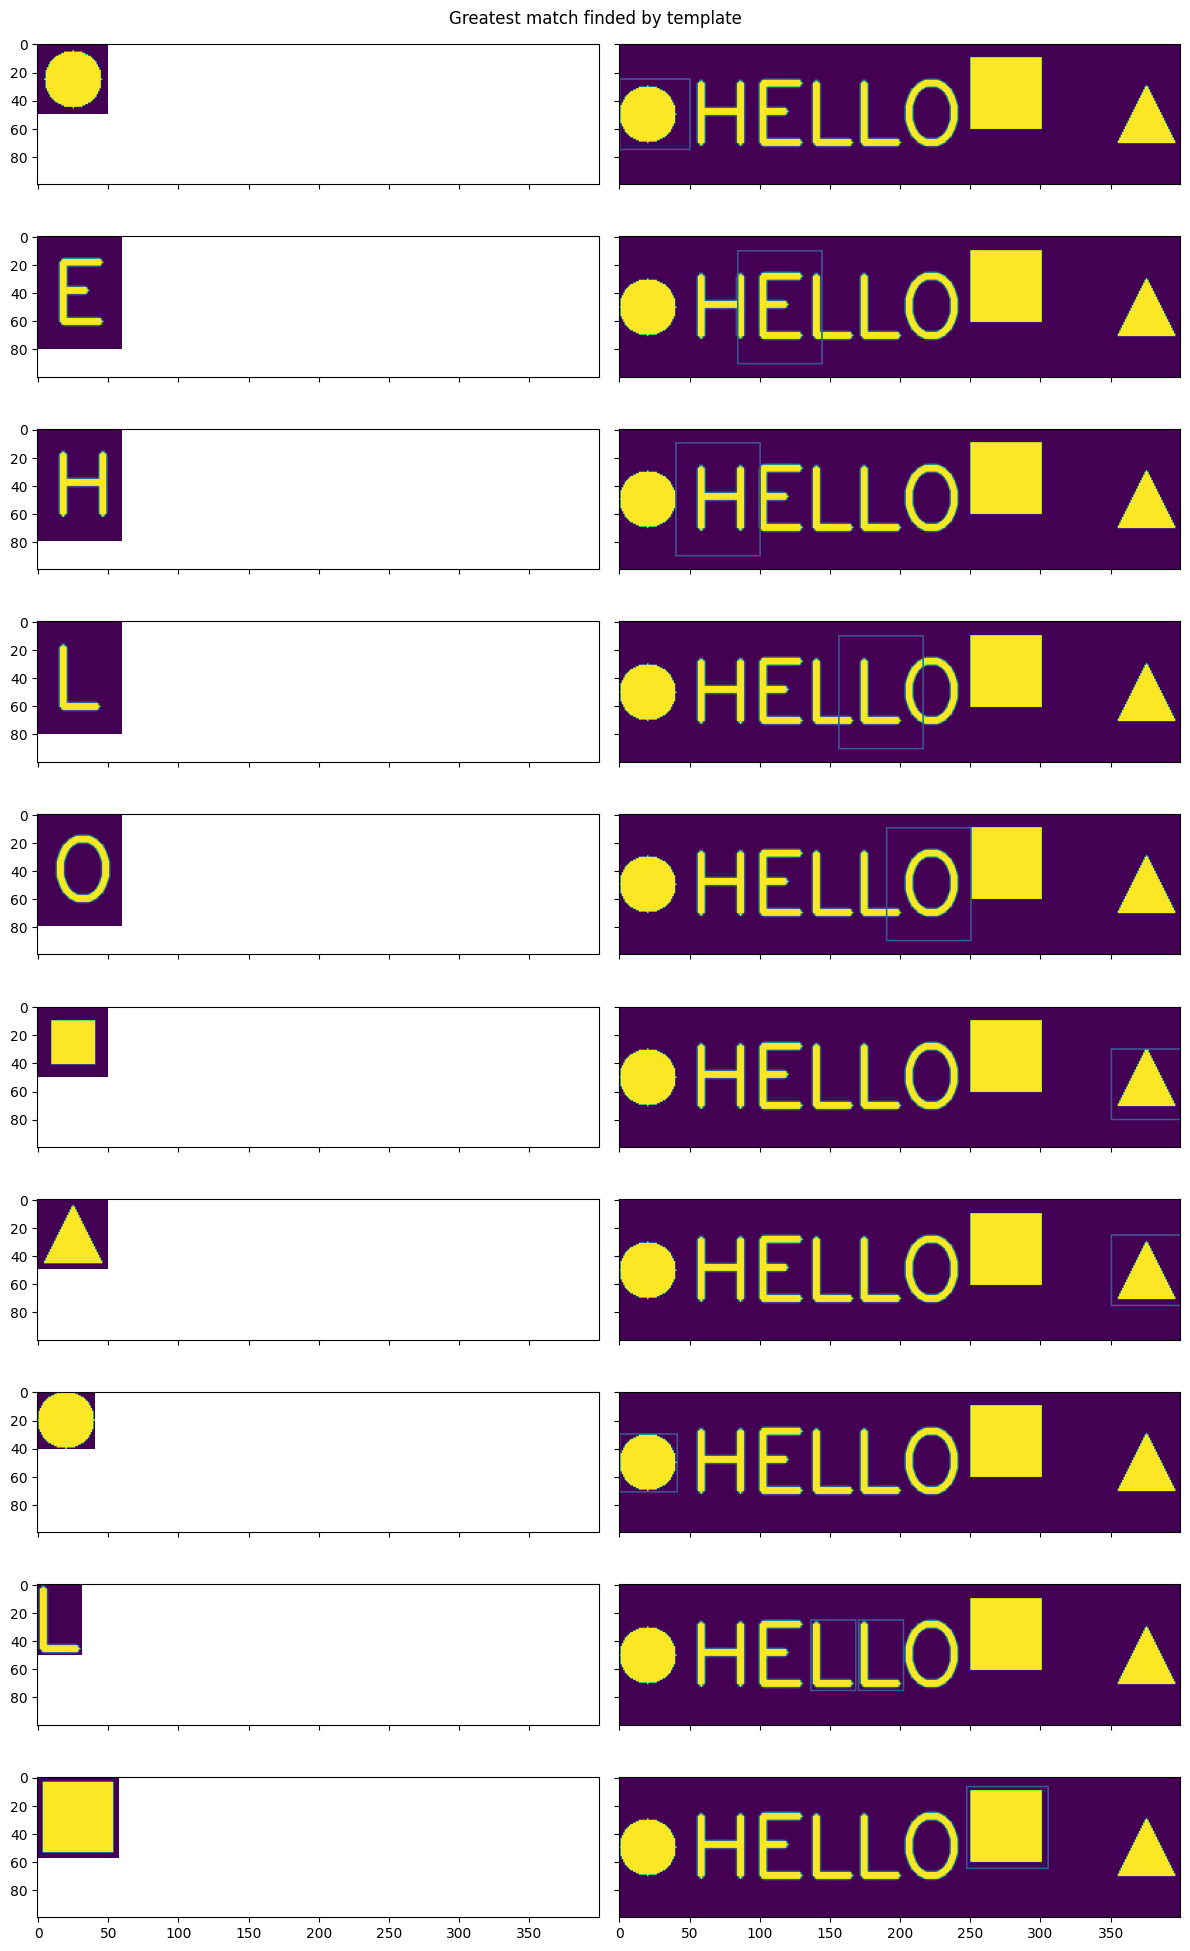

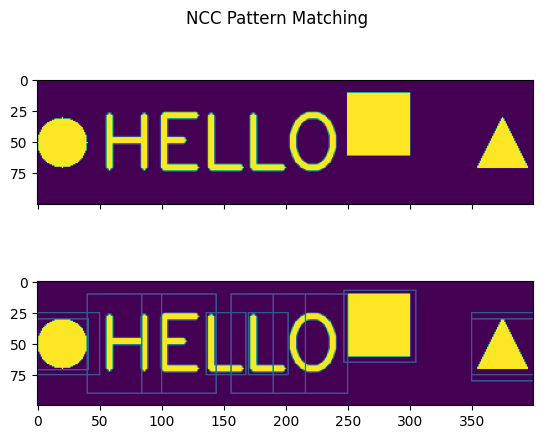

In [ ]:
# transforming urls to images
templates_images = images_list(templates_url)

# Obtaining image and a copy to draw boundaries
base_image = cv2.imread(base_image_url, cv2.IMREAD_GRAYSCALE)
bounded_image = base_image

fig, axs = plt.subplots(len(templates_images), 2, figsize=(12, 2*(len(templates_images))),sharey=True, sharex=True) # Plot for boundaries for each template
fig.suptitle("Greatest match finded by template")

for i, template_image in zip(range(len(templates_images)), templates_images):
    output, max_cordinates = NCC_template_matching(base_image, template_image) # Obtaining NCC values for each template

    axs[i,0].axis('auto') # Ploting template
    axs[i,0].imshow(template_image)

    template_bounded_image = base_image # Creating a copy for each template bounded image

    for cordinate in max_cordinates:
        template_bounded_image = draw_boundaries(template_bounded_image, template_image, cordinate) # Draw boundaries for single template plot
        bounded_image = draw_boundaries(bounded_image, template_image, cordinate) # Draw boundaries at final output plot

    # Plotting single template boundaries
    axs[i,1].axis('auto')
    axs[i,1].imshow(template_bounded_image)

fig.tight_layout()
plt.show()

# Plotting final output plot
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.suptitle("NCC Pattern Matching")
axs[0].imshow(base_image)
axs[1].imshow(bounded_image)
plt.show()

## Fourier Transform



#### **Objective**:
You are provided with three images, each corrupted by one or more periodic frequencies. Your task is to process these images using Fourier Transform techniques to identify and remove the corrupting frequencies.

- Image 1 has one specific corrupting frequency.
- Image 2 has another unique corrupting frequency.
- Image 3 has both frequencies from Image 1 and Image 2.

---

#### Guideline:
1. Use Fourier Transform to convert each image to the frequency domain. (you can use libraries for this)
2. Analyze the Fourier spectrum to identify the corrupting frequencies.
3. Remove the identified frequencies and perform an Inverse Fourier Transform to obtain the cleaned image.
4. Compare the cleaned images with the original corrupted ones and quantify the improvements.

---
#### Expected results:
- Cleaned images


---------------------------------------------------------------------------------

 Image : lenna.png 

--> Module before cleaning the corrumpus frequencies.


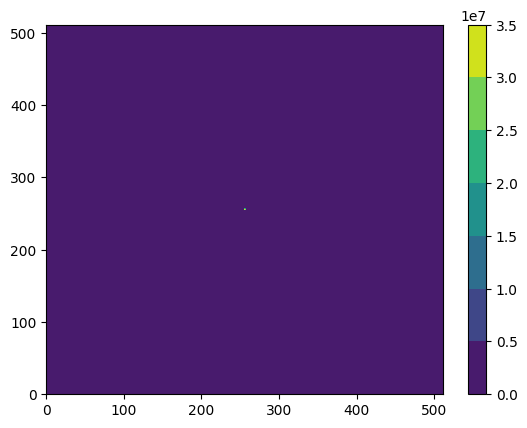

--> There are 0 points on the module that are abnormally high. These are corrumpus frequencies that need to be cleaned.
--> Module after cleaning the corrumpus frequencies.


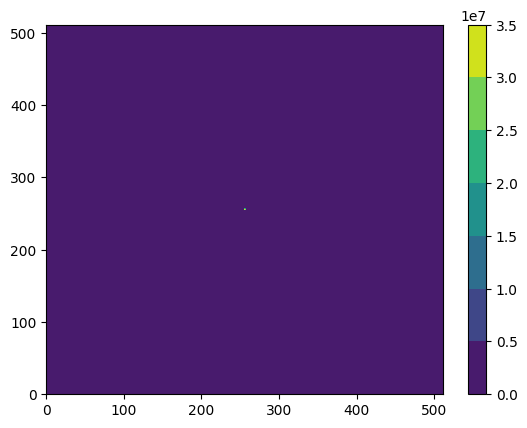

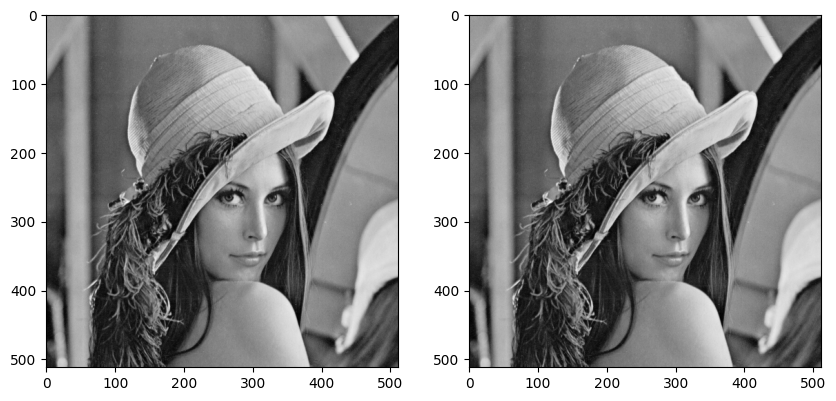

--> Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics
PSNR: 56.0 dB, PSNR %: 100.0 %, SSIM: 1.0
--> How to understand these metrics?
PSNR: The higher the PSNR, the better the quality of the cleaned image.
PSNR %: This is a personal metric that I added which allows you to reduce the PSNR as a percentage compared to its maximum value on this image. So the closer the PSNR% is to 100, the better the cleaning.
SSIM: SSIM varies between -1 and 1, the closer it is to 1 the better the cleaning.
---------------------------------------------------------------------------------

 Image : fourier_1.jpg 

--> Module before cleaning the corrumpus frequencies.


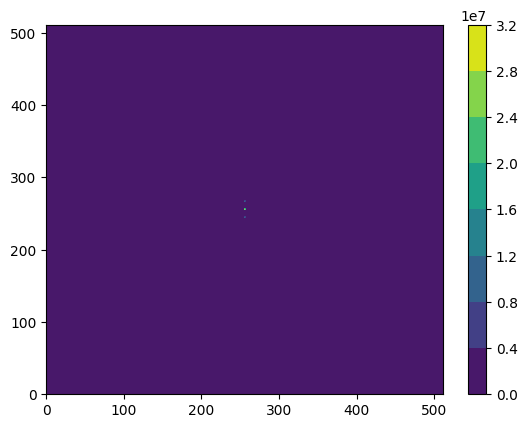

--> There are 2 points on the module that are abnormally high. These are corrumpus frequencies that need to be cleaned.
--> Module after cleaning the corrumpus frequencies.


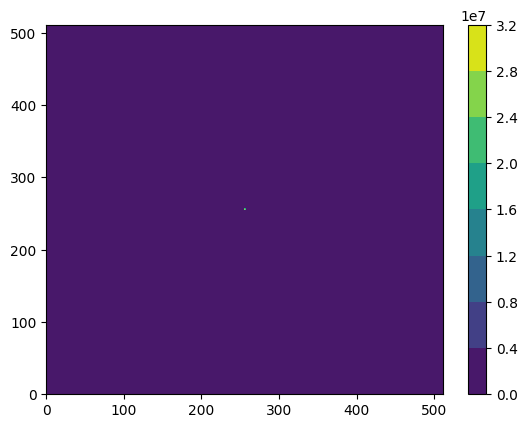

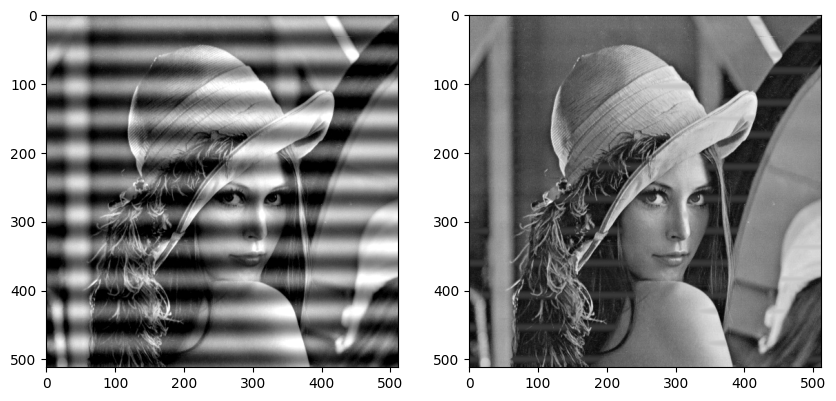

--> Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics
PSNR: 23.68 dB, PSNR %: 42.28 %, SSIM: 0.93
--> How to understand these metrics?
PSNR: The higher the PSNR, the better the quality of the cleaned image.
PSNR %: This is a personal metric that I added which allows you to reduce the PSNR as a percentage compared to its maximum value on this image. So the closer the PSNR% is to 100, the better the cleaning.
SSIM: SSIM varies between -1 and 1, the closer it is to 1 the better the cleaning.
---------------------------------------------------------------------------------

 Image : fourier_2.jpg 

--> Module before cleaning the corrumpus frequencies.


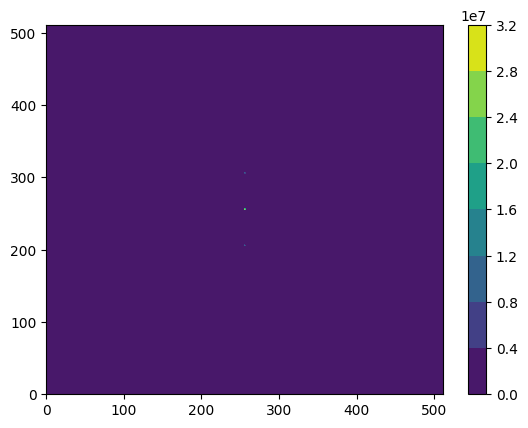

--> There are 2 points on the module that are abnormally high. These are corrumpus frequencies that need to be cleaned.
--> Module after cleaning the corrumpus frequencies.


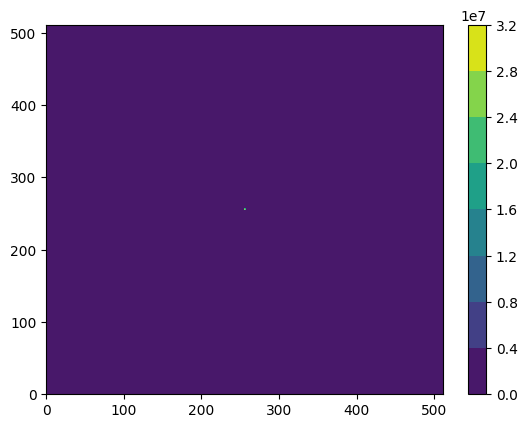

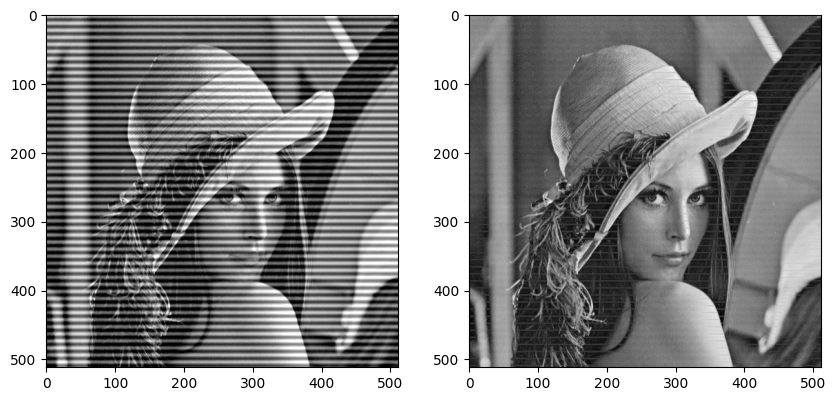

--> Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics
PSNR: 23.67 dB, PSNR %: 42.27 %, SSIM: 0.9
--> How to understand these metrics?
PSNR: The higher the PSNR, the better the quality of the cleaned image.
PSNR %: This is a personal metric that I added which allows you to reduce the PSNR as a percentage compared to its maximum value on this image. So the closer the PSNR% is to 100, the better the cleaning.
SSIM: SSIM varies between -1 and 1, the closer it is to 1 the better the cleaning.
---------------------------------------------------------------------------------

 Image : fourier_3.jpg 

--> Module before cleaning the corrumpus frequencies.


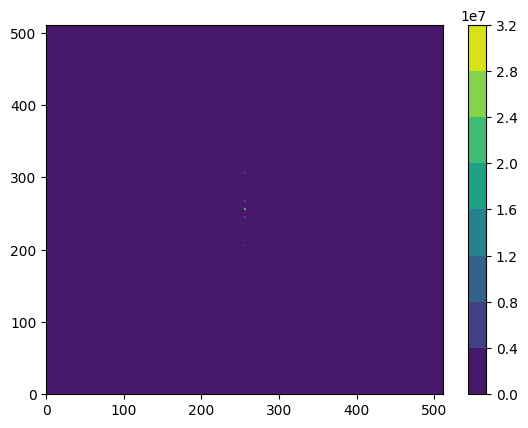

--> There are 4 points on the module that are abnormally high. These are corrumpus frequencies that need to be cleaned.
--> Module after cleaning the corrumpus frequencies.


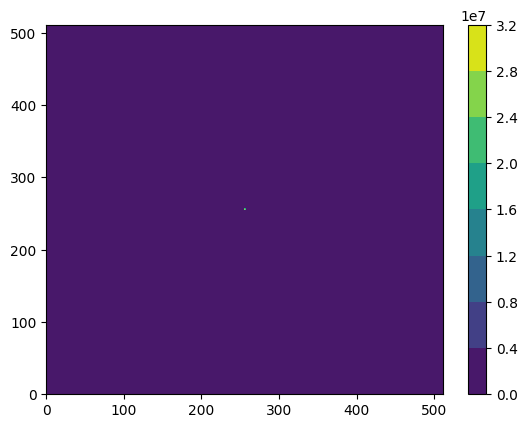

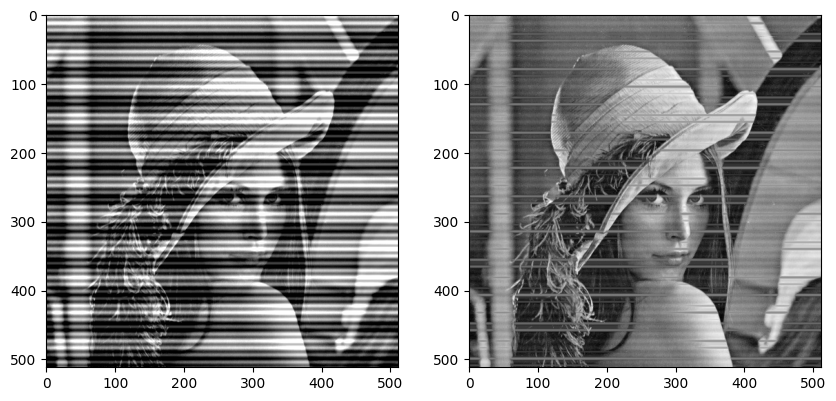

--> Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics
PSNR: 21.86 dB, PSNR %: 39.04 %, SSIM: 0.73
--> How to understand these metrics?
PSNR: The higher the PSNR, the better the quality of the cleaned image.
PSNR %: This is a personal metric that I added which allows you to reduce the PSNR as a percentage compared to its maximum value on this image. So the closer the PSNR% is to 100, the better the cleaning.
SSIM: SSIM varies between -1 and 1, the closer it is to 1 the better the cleaning.


In [ ]:
def average_neighbor(matrix, x, y):
    neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),
                (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)]
    neighbor_sum = 0
    for neighbor_x, neighbor_y in neighbors:
        if 0 <= neighbor_x < matrix.shape[0] and 0 <= neighbor_y < matrix.shape[1]:
            neighbor_sum += matrix[neighbor_x, neighbor_y]
    average = neighbor_sum / len(neighbors)
    return average

def display_module(module):
    fig, ax = plt.subplots()
    im = ax.contourf(module, cmap='viridis')
    plt.colorbar(im)
    plt.show()

def filtering(image_name):

  print("---------------------------------------------------------------------------------")
  print("\n","Image :",os.path.basename(image_name),"\n")

  # Original Image
  image_original = cv2.imread(image_name)
  image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
  image_original = image_original.astype(np.uint8)

  # Fourier Transform
  fft_image = np.fft.fft2(image_original)  # FFT -> complex frequency
  fft_image = np.fft.fftshift(fft_image)  # Center the Fourier transform

  # Module and Phase
  module = np.abs(fft_image)
  phase = np.angle(fft_image)

  # Display module
  print("--> Module before cleaning the corrumpus frequencies.")
  display_module(module)

  # Filtering
  threshold = 4000000  # Threshold determined by observation of module outliers
  indices = np.argwhere(module > threshold)  # List of indices of elements exceeding the threshold
  print(f"--> There are {len(indices)-1} points on the module that are abnormally high. These are corrumpus frequencies that need to be cleaned.")
  for index in indices:
    x, y = index[0], index[1]
    if not (x == image_original.shape[0] // 2 and y == image_original.shape[1] // 2):
      # Only the point (x, y) = (image_original.shape[0] // 2, image_original.shape[1] // 2) is irrelevant
      # It is the central peak or zero frequency peak
      # For all other retrieved points, assign them the average value of their neighbors
      module[x, y] = average_neighbor(module, x, y)

  # Display module after filtering
  print("--> Module after cleaning the corrumpus frequencies.")
  display_module(module)

  # Reconstruction of fft_image after filtering
  real_part = module * np.cos(phase)
  imag_part = module * np.sin(phase)
  complex_image = real_part + 1j * imag_part  # complex_image = filtering(fft_image)

  # Inverse Fourier Transform to reconstruct the original image after filtering
  reconstruction_after_filtering = np.fft.ifftshift(complex_image) # Inverse FFT shift
  reconstruction_after_filtering = np.fft.ifft2(reconstruction_after_filtering).real # Inverse FFT
  reconstruction_after_filtering = reconstruction_after_filtering.astype(np.uint8)  # Proper encoding
  reconstruction_after_filtering = np.clip(reconstruction_after_filtering, 0, 255)  # Values in [0, 255]

  # Displaying filter results
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(image_original, cmap='gray')
  axes[1].imshow(reconstruction_after_filtering, cmap='gray')
  plt.show()

  # Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics
  # Original uncorrupted image
  uncorrupted_image = cv2.imread(os.path.join(path_images, "lenna.png"))
  uncorrupted_image = cv2.cvtColor(uncorrupted_image, cv2.COLOR_BGR2GRAY)
  uncorrupted_image = uncorrupted_image.astype(np.uint8)
  # Calculation
  psnr_image = psnr(uncorrupted_image,reconstruction_after_filtering)
  ssim_image = ssim(uncorrupted_image,reconstruction_after_filtering)
  # Display
  print("--> Quantifying image enhancement through filtering via calculation of PSNR and SSIM metrics")
  print(f"PSNR: {round(psnr_image,2)} dB, PSNR %: {round((psnr_image/56.00450571076812)*100,2)} %, SSIM: {round(ssim_image,2)}")
  print("--> How to understand these metrics?")
  print("PSNR: The higher the PSNR, the better the quality of the cleaned image.")
  print("PSNR %: This is a personal metric that I added which allows you to reduce the PSNR as a percentage compared to its maximum value on this image. So the closer the PSNR% is to 100, the better the cleaning.")
  print("SSIM: SSIM varies between -1 and 1, the closer it is to 1 the better the cleaning.")


images = ["fourier_1.jpg", "fourier_2.jpg", "fourier_3.jpg"]
filtering(os.path.join(path_images, "lenna.png"))
for image in images:
  filtering(os.path.join(path_images, "fourier", image))
